In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [3]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [4]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [5]:
voice_data.isnull().sum().sum()

np.int64(0)

In [14]:
X = voice_data.iloc[:, :-1]
y = voice_data['label']

def transform_label(label):
    if label == 'male':
        return 1
    else:
        return 0
    

y = y.apply(transform_label)

y.value_counts()

label
1    1584
0    1584
Name: count, dtype: int64

In [15]:
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (2534, 20)
Test shape: (634, 20)


In [16]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [39]:

p = y.value_counts(normalize=True)
p

label
1    0.5
0    0.5
Name: proportion, dtype: float64

In [17]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

best_split(X_train, y_train, criterion=entropy)

(12, np.float64(0.1420971135))

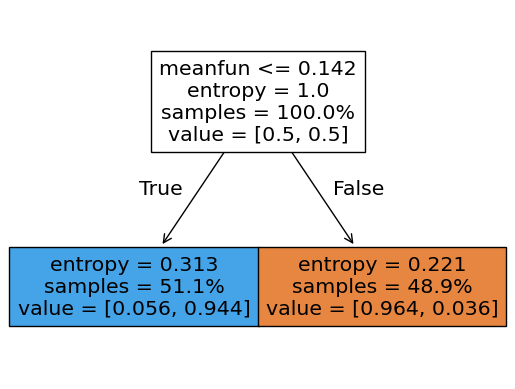

In [26]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True,
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    
);

In [27]:
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.956


In [28]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

In [29]:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

In [30]:
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

In [31]:
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=criterion)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_right, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    
    return node

In [32]:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

In [33]:
decision_tree = build_decision_tree(X_train, y_train, criterion=entropy)
print_decision_tree(decision_tree)

    feature_12 <= 0.142:
       feature_5 <= 0.074:
          feature_12 <= 0.130:
             feature_9 <= 0.438:
                feature_1 <= 0.043:
                   class: 0
                feature_1 > 0.043:
                   feature_10 <= 0.254:
                      class: 1
                   feature_10 > 0.254:
                      class: 0
             feature_9 > 0.438:
                feature_7 <= 7.539:
                   class: 1
                feature_7 > 7.539:
                   feature_0 <= 0.195:
                      class: 0
                   feature_0 > 0.195:
                      class: 1
          feature_12 > 0.130:
             feature_9 <= 0.398:
                feature_8 <= 0.897:
                   feature_1 <= 0.046:
                      class: 0
                   feature_1 > 0.046:
                      feature_1 <= 0.053:
                         class: 1
                      feature_1 > 0.053:
                         class: 0
                

In [34]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_right, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

In [35]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X_train, y_train, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_12 <= 0.142:
       feature_5 <= 0.074:
          class: 0
       feature_5 > 0.074:
          class: 1
    feature_12 > 0.142:
       feature_3 <= 0.157:
          class: 0
       feature_3 > 0.157:
          class: 0


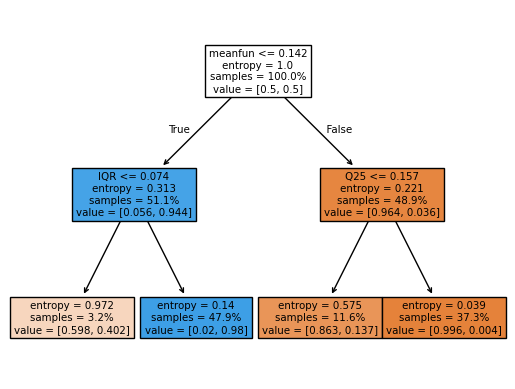

In [36]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=2, #глубина
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True,
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    
);

In [37]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X_train, y_train, criterion=entropy)
print_decision_tree(decision_tree)

    feature_12 <= 0.142:
       feature_5 <= 0.074:
          feature_12 <= 0.130:
             feature_9 <= 0.438:
                feature_1 <= 0.043:
                   class: 0
                feature_1 > 0.043:
                   feature_10 <= 0.254:
                      class: 1
                   feature_10 > 0.254:
                      class: 0
             feature_9 > 0.438:
                feature_7 <= 7.539:
                   class: 1
                feature_7 > 7.539:
                   feature_0 <= 0.195:
                      class: 0
                   feature_0 > 0.195:
                      class: 1
          feature_12 > 0.130:
             feature_9 <= 0.398:
                feature_8 <= 0.897:
                   feature_1 <= 0.046:
                      class: 0
                   feature_1 > 0.046:
                      feature_1 <= 0.053:
                         class: 1
                      feature_1 > 0.053:
                         class: 0
                

In [ ]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True,
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    
);